In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.datasets import load_wine, load_digits, fetch_olivetti_faces, load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, classification_report

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import itertools
import warnings

# Lecture 15 (Sequential Data)

## 1. Autoregressive Models

Let us now develop the mathematical framework underlying autoregressive models. These are among the most widely employed models for the analysis and forecasting of univariate time series data exhibiting nonstationarity.

## 1.1. AutoRegressive Integrated Moving Average (ARIMA) models

Let $(X_t)_{t\in\mathbb{Z}}$ denote a real-valued discrete-time stochastic process. The ARIMA model is built upon the notion that, after suitable differencing, the transformed process becomes stationary and can be modeled using a combination of autoregressive (AR) and moving average (MA) components. Formally, an ARIMA$(p,d,q)$ process satisfies the equation

$$
\phi(B)(1 - B)^d X_t = \theta(B)\varepsilon_t,
$$

where:

* $B$ is the backward shift operator defined by $BX_t = X_{t-1}$,
* $\phi(B) = 1 - \phi_1 B - \cdots - \phi_p B^p$ is the autoregressive polynomial of order $p$,
* $\theta(B) = 1 + \theta_1 B + \cdots + \theta_q B^q$ is the moving average polynomial of order $q$,
* $d$ is the order of differencing required to render the process stationary,
* $(\varepsilon_t)$ is a white noise process, i.e., a sequence of uncorrelated random variables with zero mean and constant variance $\sigma^2$.

The operator $(1 - B)^d$ encodes the $d$-fold differencing of the original process $X_t$. For instance, when $d=1$, we obtain the first difference $\Delta X_t = X_t - X_{t-1}$. The necessity of differencing is dictated by the presence of unit roots or stochastic trends in the data, and the goal is to obtain a stationary process ${Y_t = \Delta^d X_t}$ amenable to further modeling using ARMA$(p,q)$ processes.


To identify appropriate values of $p$ and $q$, one typically examines the autocorrelation function (ACF) and the partial autocorrelation function (PACF) of the differenced series. These are defined as follows. The autocorrelation function at lag $k$ is given by:

$$
\rho_k = \frac{\mathrm{Cov}(Y_t, Y_{t-k})}{\mathrm{Var}(Y_t)},
$$

where stationarity implies that the covariance depends only on the lag $k$ and not on $t$.

The partial autocorrelation function at lag $k$, denoted $\alpha_k$, measures the correlation between $Y_t$ and $Y_{t-k}$ after removing the linear effects of intermediate lags $1$ through $k-1$. Formally, it is defined as the last coefficient in the best linear predictor of $Y_t$ based on its $k$ past values:

$$
Y_t = \phi_{k1} Y_{t-1} + \phi_{k2} Y_{t-2} + \cdots + \phi_{kk} Y_{t-k} + \varepsilon_t, \quad \text{with } \alpha_k = \phi_{kk}.
$$

Empirically, the ACF and PACF plots provide guidance for model selection:

* If the ACF cuts off after lag $q$ and the PACF tails off, this suggests an MA($q$) structure.
* If the PACF cuts off after lag $p$ and the ACF tails off, this suggests an AR($p$) structure.
* If both ACF and PACF tail off slowly, differencing may be required.

The estimation of ARIMA model parameters $(\phi_1, \ldots, \phi_p, \theta_1, \ldots, \theta_q)$ is usually performed by maximum likelihood or conditional least squares methods. Once the model has been fitted, it may be validated via residual diagnostics to ensure that the residuals resemble white noise and do not exhibit significant autocorrelation, which can be tested using, for example, the Ljung–Box test.

In subsequent steps, we shall incorporate seasonal effects into this framework, leading to SARIMA models, and later address conditional heteroskedasticity through ARCH and GARCH models.

## Jena Climate Dataset

We reconsider the [**Jena Climate dataset**](https://www.kaggle.com/datasets/mnassrib/jena-climate), which comprises meteorological observations recorded at 10-minute intervals. This dataset is accessible via TensorFlow Datasets and includes variables such as temperature, pressure, and humidity. We aim to forecast future values of a selected feature based on historical sequences. 

Let us now construct an ARIMA model for the Jena Climate data using the statsmodels package. We shall focus on the univariate temperature series and follow a classical modeling workflow grounded in the Box–Jenkins methodology. The steps are as follows:

- Data preprocessing and visualization,
- Differencing and stationarity testing,
- ACF and PACF analysis,
- Model fitting with ARIMA,
- Diagnostic checking, and
- Forecasting.

### Step 1. Data preprocessing and visualization

In [2]:
url = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip'
jena_df = pd.read_csv(url, compression='zip')

# Subsample to hourly data
jena_df = jena_df[5::6].reset_index(drop=True)

# Select features
features = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
jena_data = jena_df[features].values

# Normalize features
scaler = StandardScaler()
data = scaler.fit_transform(jena_data)

# Define sequence length
sequence_length = 24  # e.g., past 24 hours

# Create sequences and targets
X = []
y = []
for i in range(len(data) - sequence_length):
    X.append(data[i:i+sequence_length])
    y.append(data[i+sequence_length][0])  # Predicting temperature

X = np.array(X)
y = np.array(y)

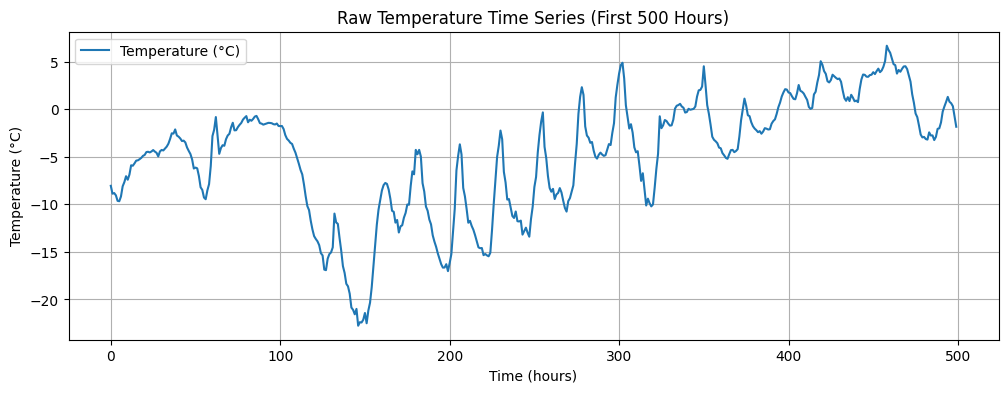

In [3]:
# Extract temperature
temperature = jena_df['T (degC)']

# Plot original series
plt.figure(figsize=(12, 4))
plt.plot(temperature[:500], label='Temperature (°C)')
plt.title("Raw Temperature Time Series (First 500 Hours)")
plt.xlabel("Time (hours)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()

### Step 2. Differencing and stationarity testing,

In [4]:
result = adfuller(temperature)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# If p-value > 0.05, perform first differencing
temperature_diff = temperature.diff().dropna()

# ADF test after differencing
result_diff = adfuller(temperature_diff)
print(f"ADF Statistic (1st difference): {result_diff[0]}")
print(f"p-value (1st difference): {result_diff[1]}")

ADF Statistic: -8.563580741044179
p-value: 8.564826672531453e-14
ADF Statistic (1st difference): -41.437843226455584
p-value (1st difference): 0.0


### Step 3. ACF and PACF analysis,

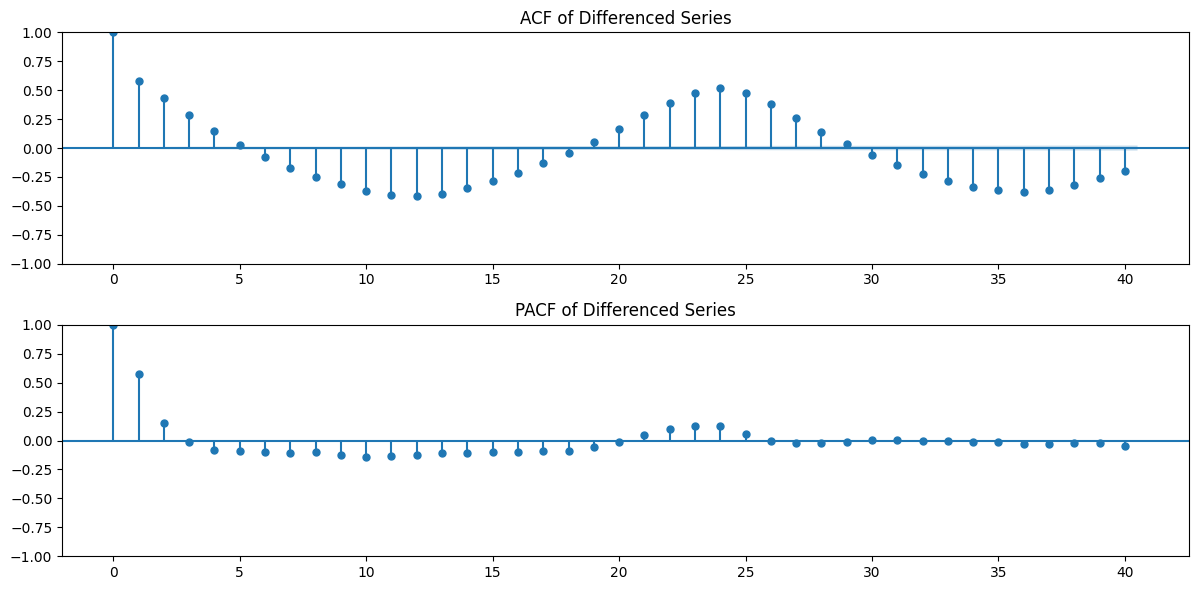

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(temperature_diff, ax=ax[0], lags=40)
plot_pacf(temperature_diff, ax=ax[1], lags=40)
ax[0].set_title("ACF of Differenced Series")
ax[1].set_title("PACF of Differenced Series")
plt.tight_layout()
plt.show()

### Step 4. Model fitting with ARIMA

In [6]:
model = ARIMA(temperature, order=(0,1,2))  # use (p,d,q) based on above ACF/PACF
fitted_model = model.fit()
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:               T (degC)   No. Observations:                70091
Model:                 ARIMA(0, 1, 2)   Log Likelihood              -87994.774
Date:                Sat, 10 May 2025   AIC                         175995.549
Time:                        22:46:26   BIC                         176023.021
Sample:                             0   HQIC                        176004.021
                              - 70091                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4591      0.002    207.420      0.000       0.455       0.463
ma.L2          0.2839      0.003    110.450      0.000       0.279       0.289
sigma2         0.7211      0.002    380.054      0.0

### Step 5. Diagnostic checking

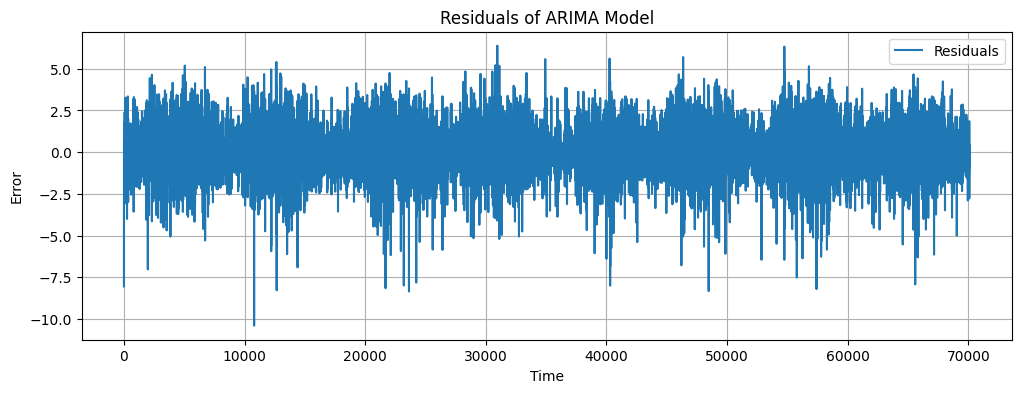

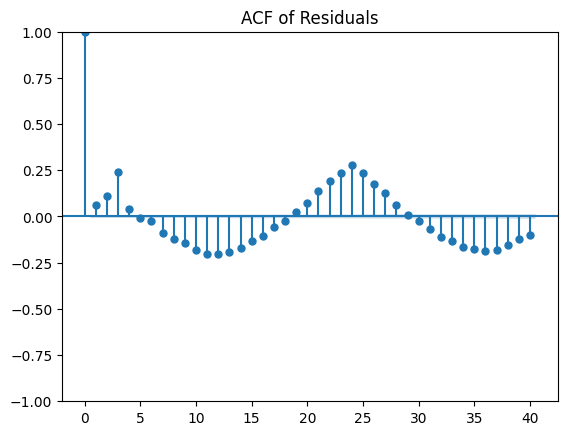

In [7]:
residuals = fitted_model.resid

plt.figure(figsize=(12, 4))
plt.plot(residuals, label='Residuals')
plt.title("Residuals of ARIMA Model")
plt.xlabel("Time")
plt.ylabel("Error")
plt.grid(True)
plt.legend()
plt.show()

# Plot ACF of residuals
plot_acf(residuals, lags=40)
plt.title("ACF of Residuals")
plt.show()


### Step 6. Forecasting.

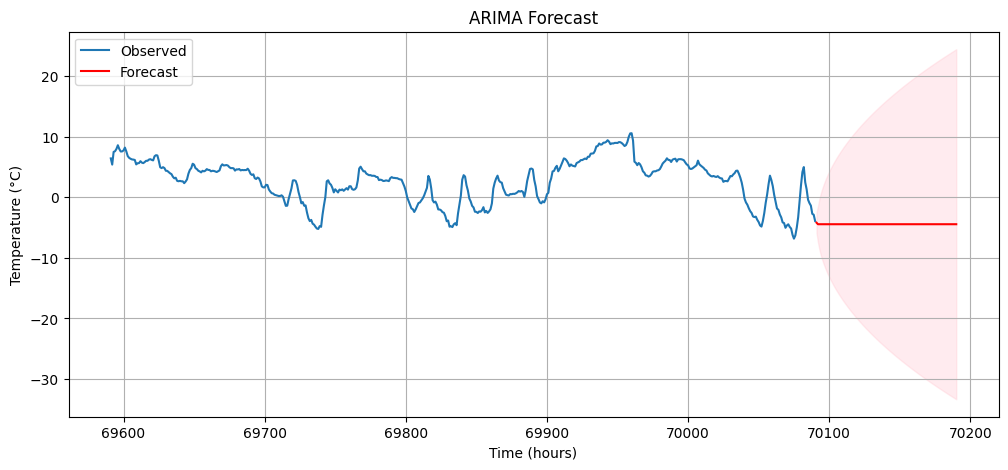

In [8]:
n_forecast = 100
forecast_result = fitted_model.get_forecast(steps=n_forecast)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Plot forecast
plt.figure(figsize=(12, 5))
plt.plot(temperature[-500:], label='Observed')
plt.plot(np.arange(len(temperature), len(temperature) + n_forecast), forecast, color='red', label='Forecast')
plt.fill_between(np.arange(len(temperature), len(temperature) + n_forecast),
                 conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("ARIMA Forecast")
plt.xlabel("Time (hours)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()

## 1.2.  Seasonal ARIMA (SARIMA) models

We now proceed to the **Seasonal ARIMA (SARIMA)** models, which are designed to handle univariate time series that exhibit **seasonal patterns** in addition to nonstationarity and short-range dependence. These models generalize ARIMA by incorporating seasonal autoregressive and moving average components and seasonal differencing operators.


### 1.2.1 Mathematical Formulation of SARIMA

Let \$(X\_t)\_{t \in \mathbb{Z}}\$ be the observed time series. A SARIMA model is denoted by:

$$
\operatorname{SARIMA}(p, d, q) \times (P, D, Q)_s,
$$

where:

* \$(p, d, q)\$ are the nonseasonal ARIMA parameters,
* \$(P, D, Q)\$ are the **seasonal** ARIMA parameters,
* \$s\$ is the seasonal period (e.g., \$s=24\$ for hourly data with daily seasonality, or \$s=168\$ for weekly cycles),
* and the model equation is:

$$
\Phi(B^s)\phi(B)\nabla^d \nabla_s^D X_t = \Theta(B^s)\theta(B)\varepsilon_t.
$$

Here:

* \$B\$ is the backward shift operator,
* \$\nabla = 1 - B\$ is the regular differencing operator,
* \$\nabla\_s = 1 - B^s\$ is the seasonal differencing operator,
* \$\phi(B)\$, \$\theta(B)\$ are the usual nonseasonal AR and MA polynomials,
* \$\Phi(B^s)\$, \$\Theta(B^s)\$ are the seasonal AR and MA polynomials.

### 1.2.2. Identifying Seasonality in the Jena Data

Let us consider daily seasonal structure, i.e., \$s = 24\$ (hours in a day).

<Figure size 1800x400 with 0 Axes>

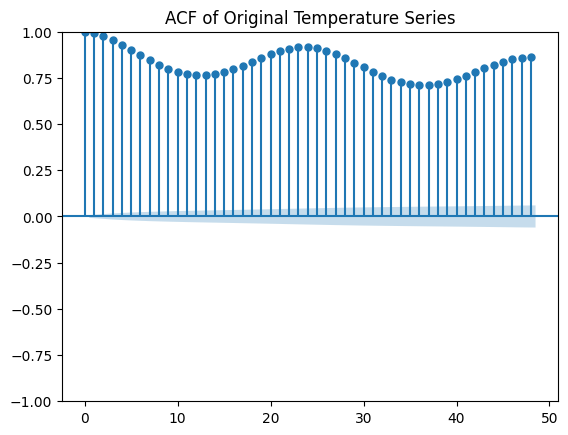

In [9]:
plt.figure(figsize=(18, 4))
plot_acf(temperature, lags=48)
plt.title("ACF of Original Temperature Series")
plt.show()

If you observe significant spikes at lags \$s\$, \$2s\$, etc., this indicates seasonal dependence.


### 1.2.3. Seasonal Differencing and Stationarity

In [10]:
# Apply seasonal differencing with period s = 24
temperature_seasonal_diff = temperature.diff(24).dropna()

adf_result = adfuller(temperature_seasonal_diff)
print(f"ADF Statistic (seasonal diff): {adf_result[0]}")
print(f"p-value (seasonal diff): {adf_result[1]}")

ADF Statistic (seasonal diff): -35.87026372657828
p-value (seasonal diff): 0.0


If the seasonal difference is still nonstationary, apply an additional first difference:

In [11]:
temperature_diff2 = temperature_seasonal_diff.diff().dropna()

adf_result2 = adfuller(temperature_diff2)
print(f"ADF Statistic (seasonal + first diff): {adf_result2[0]}")
print(f"p-value (seasonal + first diff): {adf_result2[1]}")

ADF Statistic (seasonal + first diff): -55.131772180111206
p-value (seasonal + first diff): 0.0


### 1.2.4. Fit SARIMA Model with `statsmodels`

Assume we observed that \$(p,d,q) = (1,1,1)\$ and \$(P,D,Q,s) = (1,1,1,24)\$ give a good fit.

In [12]:
# Fit SARIMA
model = SARIMAX(
    temperature,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 24),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_result = model.fit()
print(sarima_result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           T (degC)   No. Observations:                70091
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood              -77569.061
Date:                            Sat, 10 May 2025   AIC                         155148.123
Time:                                    22:51:36   BIC                         155193.907
Sample:                                         0   HQIC                        155162.243
                                          - 70091                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5238      0.008     62.448      0.000       0.507       0.540
ma.L1         -0.2587      0.009   

### 1.2.5. Residual Diagnostics

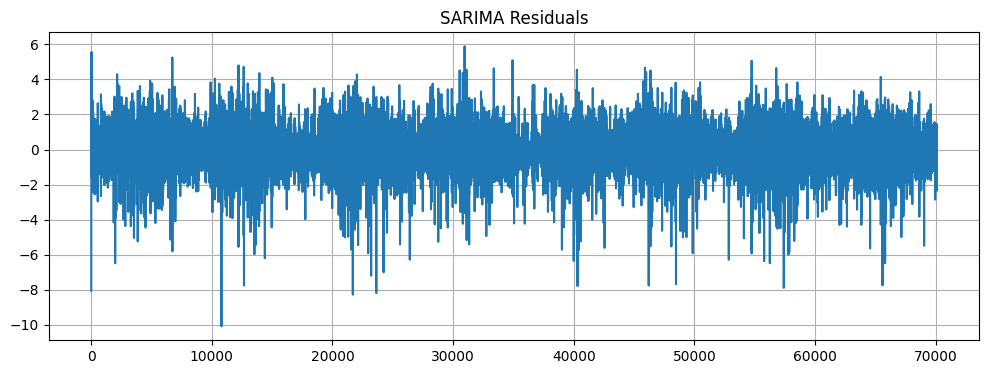

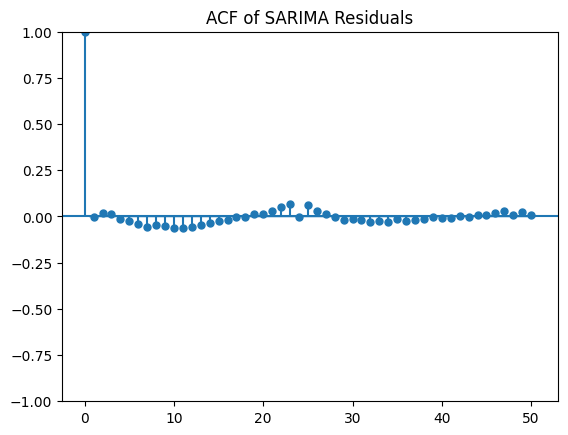

In [13]:
resid = sarima_result.resid

plt.figure(figsize=(12, 4))
plt.plot(resid)
plt.title("SARIMA Residuals")
plt.grid(True)
plt.show()

# ACF of residuals
plot_acf(resid, lags=50)
plt.title("ACF of SARIMA Residuals")
plt.show()

The residuals should be approximately white noise. If not, consider adjusting model orders.


### 1.2.6. Forecasting with SARIMA

In [14]:
forecast_steps = 168  # forecast one week ahead (24 * 7)
sarima_forecast = sarima_result.get_forecast(steps=forecast_steps)

mean_forecast = sarima_forecast.predicted_mean
conf_int = sarima_forecast.conf_int()

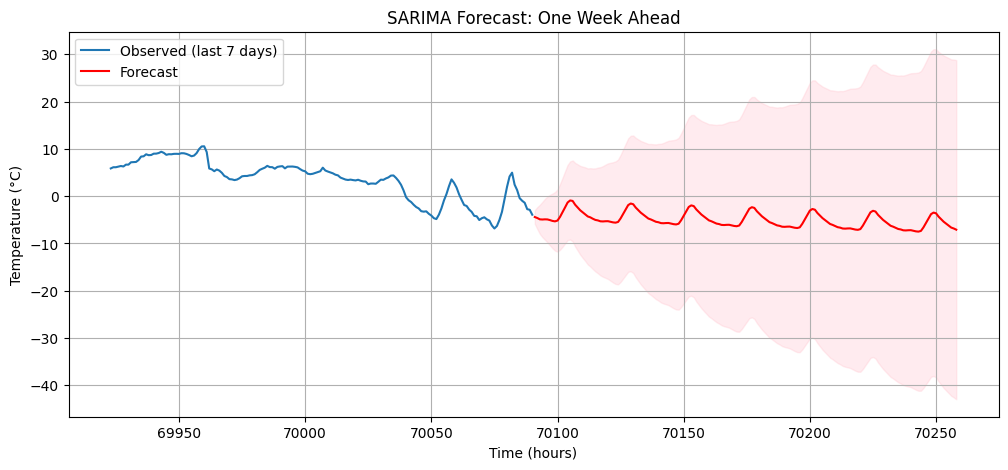

In [15]:
# Plot
plt.figure(figsize=(12, 5))
plt.plot(temperature[-7*24:], label='Observed (last 7 days)')
plt.plot(np.arange(len(temperature), len(temperature)+forecast_steps), mean_forecast, label='Forecast', color='red')
plt.fill_between(np.arange(len(temperature), len(temperature)+forecast_steps),
                 conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("SARIMA Forecast: One Week Ahead")
plt.xlabel("Time (hours)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()

### 1.2.7. Brute Force Search for (S)ARIMA Parameters


In [16]:
def sarima_grid_search(y, pdq_range, seasonal_pdq_range, s):
    best_aic = np.inf
    best_order = None
    best_seasonal_order = None
    best_model = None

    for order in pdq_range:
        for seasonal_order in seasonal_pdq_range:
            seasonal_order_full = (seasonal_order[0], seasonal_order[1], seasonal_order[2], s)
            try:
                model = SARIMAX(y, order=order, seasonal_order=seasonal_order_full,
                                enforce_stationarity=False, enforce_invertibility=False)
                result = model.fit(disp=False)
                if result.aic < best_aic:
                    best_aic = result.aic
                    best_order = order
                    best_seasonal_order = seasonal_order_full
                    best_model = result
            except:
                continue
    return best_model, best_order, best_seasonal_order, best_aic

In [ ]:
# Example usage:
pdq = list(itertools.product(range(2), range(2), range(2)))
seasonal_pdq = list(itertools.product(range(2), range(2), range(2)))
model, order, seasonal_order, aic = sarima_grid_search(temperature, pdq, seasonal_pdq, s=24)
print(f"Best SARIMA{order}x{seasonal_order} - AIC: {aic}")

# 2. Neural Network Models

## 2.1. Recurrent Neural Networks (RNNs)

RNNs are a class of function approximators within reinforcement learning, particularly well-suited for sequential decision-making problems where the Markov property is violated or where the state of the environment is only partially observable. In such scenarios, an agent's optimal action may depend not merely on the current observation but on the entire history of past observations and actions. RNNs, by virtue of their inherent recurrent connections, can maintain an internal state or memory that summarizes relevant aspects of this history, thereby enabling more informed decision-making. By learning to compress relevant historical information into their hidden states, they enable agents to tackle a broader range of complex tasks characterized by partial observability and long-term dependencies, thereby significantly expanding the applicability of reinforcement learning techniques.

## 2.1.1. Formal Definition

An RNN processes a sequence of inputs $x_0, x_1, \dots, x_T$ one element at a time. At each time step $t$, the network computes a hidden state $h_t$ and an output $y_t$. The hidden state $h_t$ is a function of the previous hidden state $h_{t-1}$ and the current input $x_t$. This recurrent dependency allows the network to capture temporal dependencies in the input sequence. Mathematically, the dynamics of a simple RNN can be described by the following equations:

$$h_t = f(W_{xh} x_t + W_{hh} h_{t-1} + b_h)$$
$$y_t = g(W_{hy} h_t + b_y)$$

Here, $x_t$ is the input at time step $t$, $h_t \in \mathbb{R}^n$ is the hidden state vector (with $h_0$ typically initialized to a zero vector or a learned initial state), and $y_t$ is the output. $W_{xh}$, $W_{hh}$, and $W_{hy}$ are weight matrices connecting the input to the hidden layer, the previous hidden layer to the current hidden layer, and the hidden layer to the output layer, respectively. $b_h$ and $b_y$ are bias vectors. The functions $f$ and $g$ are element-wise activation functions; $f$ is often a hyperbolic tangent ($\tanh$) or a Rectified Linear Unit (ReLU), while $g$ depends on the nature of the output (e.g., a linear function for value estimation, or a softmax function for action probabilities). The collection of all weight matrices and biases constitutes the parameters $\theta$ of the RNN.

## 2.1.2. Training RNNs

Training RNNs in reinforcement learning involves Backpropagation Through Time (BPTT). The gradients of the loss function (for value-based methods) or the policy performance objective (for policy-based methods) with respect to the RNN parameters $\theta$ are computed by unrolling the network over a sequence of time steps and applying the chain rule. For long sequences, full BPTT can be computationally expensive and may suffer from vanishing or exploding gradients. Truncated BPTT, where gradients are backpropagated only for a limited number of recent time steps, is often used as a practical compromise.

To mitigate the vanishing/exploding gradient problem and to better capture long-range temporal dependencies, more sophisticated recurrent architectures like Long Short-Term Memory (LSTM) units or Gated Recurrent Units (GRUs) are commonly preferred over simple RNNs. An LSTM unit, for instance, incorporates a cell state $c_t$ and gating mechanisms (input gate $i_t$, forget gate $f_t$, and output gate $o_t$) to regulate the flow of information. The equations for an LSTM layer are:

$$f_t = \sigma(W_{xf} x_t + W_{hf} h_{t-1} + b_f)$$$$i_t = \sigma(W_{xi} x_t + W_{hi} h_{t-1} + b_i)$$
$$g_t = \tanh(W_{xc} x_t + W_{hc} h_{t-1} + b_c) \quad (\text{candidate values})$$
$$c_t = f_t \odot c_{t-1} + i_t \odot g_t \quad (\text{cell state update})$$$$o_t = \sigma(W_{xo} x_t + W_{ho} h_{t-1} + b_o)$$
$$h_t = o_t \odot \tanh(c_t) \quad (\text{hidden state/output})$$

Here, $\sigma$ denotes the sigmoid function, and $\odot$ represents element-wise multiplication. These gates allow LSTMs to selectively remember or forget information over extended periods. GRUs offer a slightly simpler gated architecture with similar performance on many tasks.

## 2.1.3. Use Cases

In the context of reinforcement learning, RNNs can be employed to approximate value functions, policies, or even environment models. When applied to partially observable Markov decision processes (POMDPs), the input $x_t$ to the RNN is typically the observation $o_t$ received from the environment. The hidden state $h_t$ can be interpreted as a learned representation of the belief state, summarizing the history of observations $(o_1, \dots, o_t)$ and actions $(a_1, \dots, a_{t-1})$ to approximate the true underlying state of the environment.

RNNs can represent policies directly in policy-based or actor-critic methods. In this setting, often called a recurrent policy, the RNN takes the current observation $o_t$ (and incorporates $h_{t-1}$) and outputs parameters for a probability distribution over actions, $\pi(a_t | o_t, h_{t-1}; \theta)$. For discrete action spaces, the output layer might use a softmax function to produce probabilities for each action. For continuous action spaces, the RNN might output the mean and variance of a Gaussian distribution from which the action is sampled. Policy gradient methods, such as REINFORCE or A2C/A3C, are then used to update the policy parameters $\theta$. The objective function $J(\theta)$ is maximized, and its gradient typically takes the form:

$$\nabla_\theta J(\theta) = E_{\tau \sim \pi_\theta} \left[ \sum_{t=0}^{T-1} \nabla_\theta \log \pi(a_t | o_t, h_{t-1}; \theta) A_t \right]$$

where $A_t$ is an estimate of the advantage function (e.g., $G_t - V(o_t, h_{t-1})$). In actor-critic architectures, both the actor (policy) and the critic (value function) can be implemented using RNNs, potentially sharing some initial recurrent layers to process the observation sequence before branching into separate output heads.

## 2.2. Long Short-Term Memory (LSTM) Networks

LSTMs were introduced to resolve this instability. The core idea is to control information flow through **gates** and to maintain a separate **cell state** $c_t$ in addition to the hidden state $h_t$. The update equations are:

$$
\begin{aligned}
i_t &= \sigma(W_{xi} x_t + W_{hi} h_{t-1} + b_i), &\text{(input gate)} \\
f_t &= \sigma(W_{xf} x_t + W_{hf} h_{t-1} + b_f), &\text{(forget gate)} \\
o_t &= \sigma(W_{xo} x_t + W_{ho} h_{t-1} + b_o), &\text{(output gate)} \\
g_t &= \tanh(W_{xg} x_t + W_{hg} h_{t-1} + b_g), &\text{(cell candidate)} \\
c_t &= f_t \odot c_{t-1} + i_t \odot g_t, &\text{(cell state update)} \\
h_t &= o_t \odot \tanh(c_t), &\text{(hidden state update)}
\end{aligned}
$$

where $\odot$ denotes the Hadamard (element-wise) product, and all gates use the sigmoid activation $\sigma(z) = 1 / (1 + e^{-z})$.

The gating mechanisms enable selective retention and erasure of memory, allowing gradients to propagate through long time intervals without vanishing. The key theoretical advantage lies in the near-identity path from $c_{t-1}$ to $c_t$ when $f_t \approx 1$ and $i_t \approx 0$.

## 2.3. A Computational Example on Jena Climate Data

### An RNN Network on Jena Climate Data

Let us start by resampling the data:

In [4]:
# Subsample hourly (original: 10-minute intervals)
df = jena_df[5::6].reset_index(drop=True)

# Select features and target: we predict 'T (degC)' from multivariate input
features = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
data = df[features].values

# Normalize features
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Sequence construction
window_size = 24  # 24 hours
X = []
y = []
for i in range(len(data) - window_size):
    X.append(data[i:i+window_size])
    y.append(data[i+window_size][0])  # Predict next-step temperature

X = np.array(X)
y = np.array(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

Next, we define out NN class:

In [5]:
class ClimateRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(ClimateRNN, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, h_n = self.rnn(x)
        return self.fc(h_n[-1])

Let us instantiate the class, choose our loss function and our optimizer:

In [6]:
model = ClimateRNN(input_dim=3, hidden_dim=64, num_layers=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Next, we train our model and evaluate the performance:

In [7]:
epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

Epoch 0, Loss: 26.3252
Epoch 5, Loss: 10.2469
Epoch 10, Loss: 9.6457
Epoch 15, Loss: 9.4520
Epoch 20, Loss: 9.1677
Epoch 25, Loss: 8.9815
Epoch 30, Loss: 8.7758
Epoch 35, Loss: 8.7035
Epoch 40, Loss: 8.6896
Epoch 45, Loss: 8.3897


In [8]:
model.eval()
with torch.no_grad():
    preds = []
    targets = []
    for xb, yb in test_loader:
        out = model(xb)
        preds.append(out.numpy())
        targets.append(yb.numpy())

# Stack and inverse-transform temperature
preds = np.vstack(preds)
targets = np.vstack(targets)
mse = mean_squared_error(targets, preds)
print(f"Test MSE: {mse:.4f}")

Test MSE: 0.0578


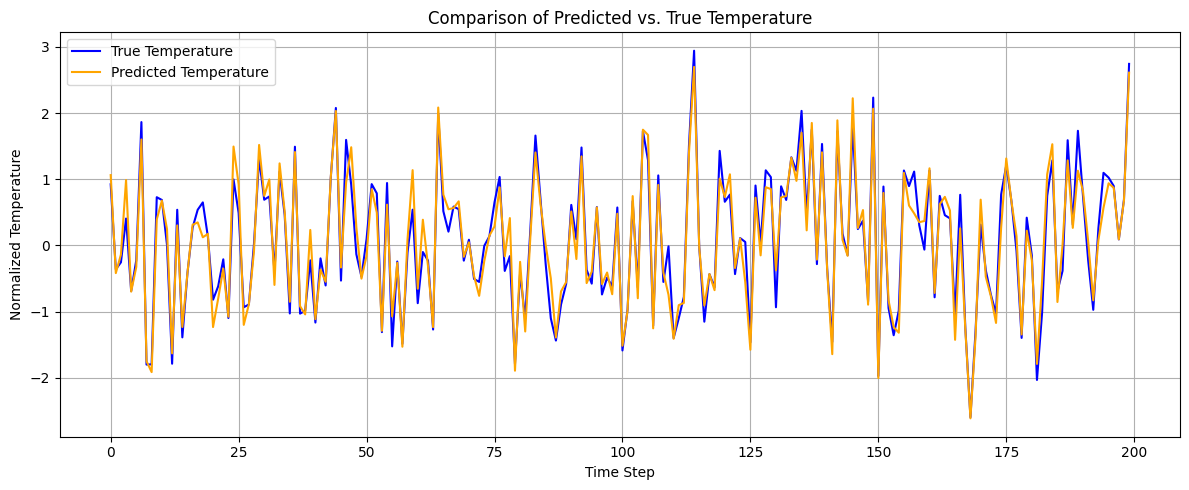

In [9]:
preds_flat = preds.flatten()
targets_flat = targets.flatten()

# Plot first 200 samples for clarity
plt.figure(figsize=(12, 5))
plt.plot(targets_flat[:200], label='True Temperature', color='blue')
plt.plot(preds_flat[:200], label='Predicted Temperature', color='orange')
plt.xlabel('Time Step')
plt.ylabel('Normalized Temperature')
plt.title('Comparison of Predicted vs. True Temperature')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### A LSTM Network on Jena Climate Data

Let us now implement a **PyTorch LSTM model** on the same **Jena Climate dataset** used previously for the RNN example. We'll reuse the preprocessed sequences, train a new LSTM-based regressor, and finish with a visualization comparing predictions to true temperature values.

In [10]:
class ClimateLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(ClimateLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # LSTM returns (output_seq, (h_n, c_n)), we use the last hidden state
        out, (h_n, _) = self.lstm(x)
        return self.fc(h_n[-1])

In [11]:
lstm_model = ClimateLSTM(input_dim=3, hidden_dim=64, num_layers=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

In [12]:
epochs = 50
for epoch in range(epochs):
    lstm_model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = lstm_model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

Epoch 0, Loss: 43.4518
Epoch 5, Loss: 10.6099
Epoch 10, Loss: 9.7294
Epoch 15, Loss: 9.3554
Epoch 20, Loss: 8.9865
Epoch 25, Loss: 8.7783
Epoch 30, Loss: 8.6006
Epoch 35, Loss: 8.5283
Epoch 40, Loss: 8.3598
Epoch 45, Loss: 8.1701


In [13]:
# Evaluation
lstm_model.eval()
preds, targets = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        out = lstm_model(xb)
        preds.append(out.numpy())
        targets.append(yb.numpy())

preds = np.vstack(preds)
targets = np.vstack(targets)
mse = mean_squared_error(targets, preds)
print(f"Test MSE: {mse:.4f}")

Test MSE: 0.0577


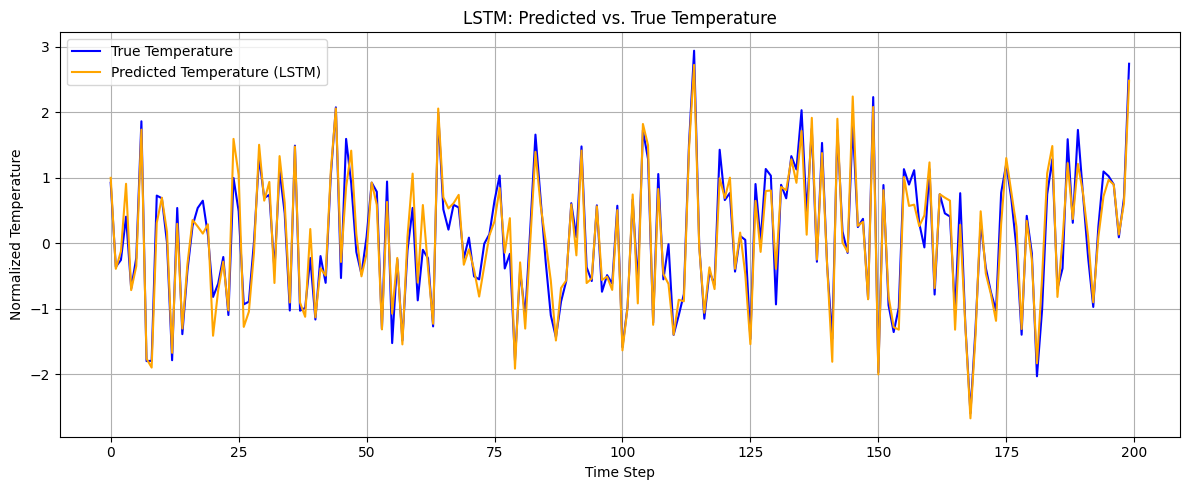

In [14]:
preds_flat = preds.flatten()
targets_flat = targets.flatten()

plt.figure(figsize=(12, 5))
plt.plot(targets_flat[:200], label='True Temperature', color='blue')
plt.plot(preds_flat[:200], label='Predicted Temperature (LSTM)', color='orange')
plt.xlabel('Time Step')
plt.ylabel('Normalized Temperature')
plt.title('LSTM: Predicted vs. True Temperature')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()